# 数据规整：聚合、合并和重塑 

In [1]:
import numpy as np
import pandas as pd

### 层次化索引

层次化索引（hierarchical indexing）是 pandas 的一项重要功能，它使你能
在一个轴上拥有多个（两个以上）索引级别。抽象点说，它使你能以低维度形
式处理高维度数据。

In [2]:
data = pd.Series(np.random.randn(9),
                index=[['a', 'a', 'a', 'b', 'b', 'c', 'c','d', 'd'],
                       [1, 2, 3, 1, 3, 1, 2, 2, 3]])

In [3]:
data

a  1   -0.063499
   2    0.497763
   3    0.777315
b  1   -0.410874
   3    0.622584
c  1    0.462245
   2   -1.024908
d  2   -0.483535
   3    2.185749
dtype: float64

看到的结果是经过美化的带有 MultiIndex 索引的 Series 的格式。索引之间的
“间隔”表示“直接使用上面的标签

In [4]:
data.index

MultiIndex(levels=[['a', 'b', 'c', 'd'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 0, 2, 0, 1, 1, 2]])

对于一个层次化索引的对象，可以使用所谓的部分索引，使用它选取数据子集
的操作更简单

In [5]:
data['b']

1   -0.410874
3    0.622584
dtype: float64

In [6]:
data['b':'c']

b  1   -0.410874
   3    0.622584
c  1    0.462245
   2   -1.024908
dtype: float64

In [7]:
data.loc[['b', 'd']]

b  1   -0.410874
   3    0.622584
d  2   -0.483535
   3    2.185749
dtype: float64

In [8]:
data.loc['b']

1   -0.410874
3    0.622584
dtype: float64

有时甚至还可以在“内层”中进行选取：


In [9]:
data.loc[:,2]

a    0.497763
c   -1.024908
d   -0.483535
dtype: float64

层次化索引在数据重塑和基于分组的操作（如透视表生成）中扮演着重要的角
色。例如，可以通过 unstack 方法将这段数据重新安排到一个 DataFrame 中

In [10]:
data.unstack()

,1,2,3
a,-0.063499,0.497763,0.777315
b,-0.410874,NaN,0.622584
c,0.462245,-1.024908,NaN
d,NaN,-0.483535,2.185749


unstack 的逆运算是 stack：

In [11]:
data.unstack().stack()

a  1   -0.063499
   2    0.497763
   3    0.777315
b  1   -0.410874
   3    0.622584
c  1    0.462245
   2   -1.024908
d  2   -0.483535
   3    2.185749
dtype: float64

对于一个 DataFrame，每条轴都可以有分层索引：

In [12]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
                    index=[['a','a','b','b'], [1, 2, 1, 2]],
                    columns=[['Ohio', 'Ohio', 'Colorado'],
                             ['Green', 'Red', 'Green']])

In [13]:
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

各层都可以有名字（可以是字符串，也可以是别的 Python 对象）。如果指定了
名称，它们就会显示在控制台输出中：

In [14]:
frame.index.names = ['key1', 'key2']

In [15]:
frame.columns.names = ['state', 'color']

In [16]:
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

注意：小心区分索引名 state、color 与行标签

In [18]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

可以单独创建 MultiIndex 然后复用。上面那个 DataFrame 中的（带有分级名
称）列可以这样创建：

### 重排与分级排序

有时，你需要重新调整某条轴上各级别的顺序，或根据指定级别上的值对数据
进行排序。swaplevel 接受两个级别编号或名称，并返回一个互换了级别的新
对象（但数据不会发生变化）：

In [21]:
frame.swaplevel('key1', 'key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

而 sort_index 则根据单个级别中的值对数据进行排序。交换级别时，常常也会
用到 sort_index，这样最终结果就是按照指定顺序进行字母排序了

In [22]:
frame.sort_index(level=1)

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [23]:
frame.swaplevel(0, 1).sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

## 根据级别汇总统计

许多对 DataFrame 和 Series 的描述和汇总统计都有一个 level 选项，它用于指
定在某条轴上求和的级别

In [24]:
frame.sum(level='key2')

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [25]:
frame.sum(level='color', axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

### 使用 DataFrame 的列进行索引

In [26]:
frame = pd.DataFrame({'a': range(7), 'b': range(7, 0, -1),
                      'c': ['one', 'one', 'one', 'two','two','two', 'two'],
                      'd': [0, 1, 2, 0, 1, 2, 3]})

In [27]:
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


DataFrame 的 set_index 函数会将其一个或多个列转换为行索引，并创建一个
新的 DataFrame：

In [28]:
frame2 = frame.set_index(['c', 'd'])

In [29]:
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

默认情况下，那些列会从 DataFrame 中移除，但也可以将其保留下来：

In [30]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

reset_index 的功能跟 set_index 刚好相反，层次化索引的级别会被转移到列

In [31]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


## 合并数据集

pandas 对象中的数据可以通过一些方式进行合并：

 pandas.merge 可根据一个或多个键将不同 DataFrame 中的行连接起来。SQL 或其他
关系型数据库的用户对此应该会比较熟悉，因为它实现的就是数据库的 join 操作。

 pandas.concat 可以沿着一条轴将多个对象堆叠到一起。

 实例方法 combine_first 可以将重复数据编接在一起，用一个对象中的值填充另一个
对象中的缺失值。

#### 数据库风格的 DataFrame 合并

In [32]:
 df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a','b'],
                     'data1': range(7)})

In [33]:
df2 = pd.DataFrame({'key': ['a', 'b', 'd'], 
                    'data2': range(3)})

In [34]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [35]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


In [36]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


注意，我并没有指明要用哪个列进行连接。如果没有指定，merge 就会将重叠
列的列名当做键。不过，最好明确指定一下：

In [37]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


In [38]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a','b'],
                    'data1': range(7)})
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                    'data2': range(3)})

In [39]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


可能你已经注意到了，结果里面 c 和 d 以及与之相关的数据消失了。默认情况
下，merge 做的是“内连接”；结果中的键是交集。其他方式还有"left"、
"right"以及"outer"。外连接求取的是键的并集，组合了左连接和右连接的效
果：

In [40]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


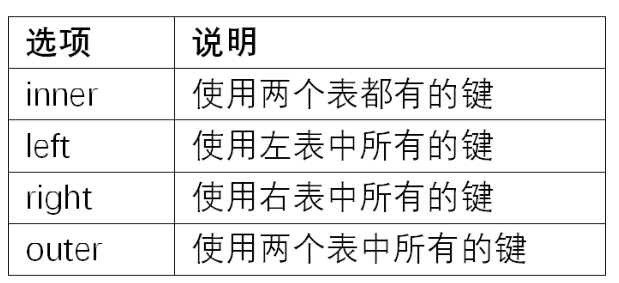

In [41]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})
df2 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                    'data2': range(5)})

In [42]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [43]:
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [44]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


多对多连接产生的是行的笛卡尔积。由于左边的 DataFrame 有 3 个"b"行，右边
的有 2 个，所以最终结果中就有 6 个"b"行。连接方式只影响出现在结果中的不
同的键的值

In [45]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


In [46]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})

right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'], 
                      'rval': [4, 5, 6, 7]})

In [48]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


In [49]:
 pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


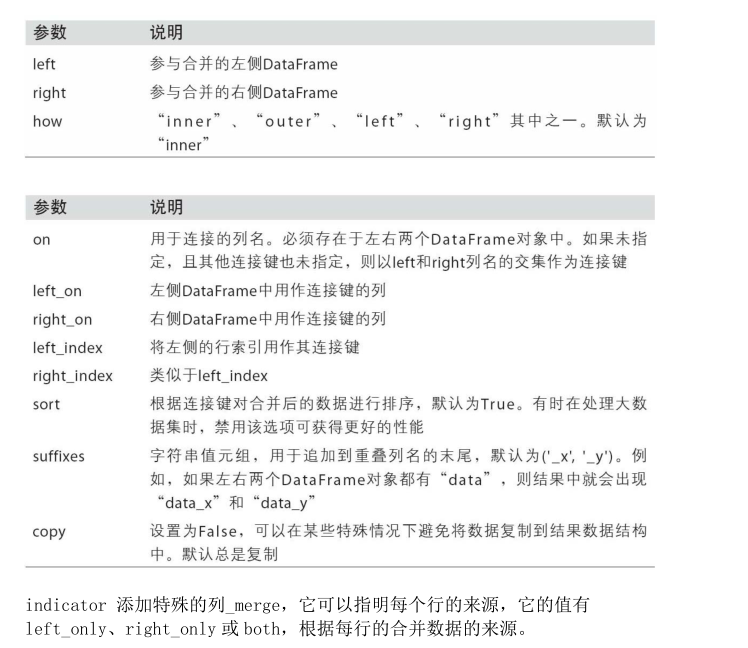m

## 索引上的合并

In [50]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                      'value': range(6)})
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])

In [51]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [52]:
right1

,group_val
a,3.5
b,7.0


In [53]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


In [54]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


In [56]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
                               'Nevada', 'Nevada'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index=[['Nevada', 'Nevada', 'Ohio', 'Ohio',
                              'Ohio', 'Ohio'],
                             [2001, 2000, 2000, 2000, 2001, 2002]],
                      columns=['event1', 'event2'])
lefth


,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [57]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

必须以列表的形式指明用作合并键的多个列（注意用
how='outer'对重复索引值的处理）

In [59]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [60]:
pd.merge(lefth, righth, left_on=['key1', 'key2'],
         right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


In [61]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                     index=['a', 'c', 'e'],
                     columns=['Ohio', 'Nevada'])
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                      index=['b', 'c', 'd', 'e'],
                      columns=['Missouri', 'Alabama'])

In [63]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [64]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [65]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [66]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [67]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


## 轴向连接

In [68]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [69]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In [70]:
np.concatenate([arr, arr], axis=0)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [71]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])
s3 = pd.Series([5, 6], index=['f', 'g'])

In [72]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

默认情况下，concat 是在 axis=0 上工作的，最终产生一个新的 Series。如果
传入 axis=1，则结果就会变成一个 DataFrame（axis=1 是列）：

In [74]:
pd.concat([s1, s2, s3], axis=1)

C:\Users\69547\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [75]:
s4 = pd.concat([s1, s3])

In [76]:
s4

a    0
b    1
f    5
g    6
dtype: int64

In [77]:
pd.concat([s1, s4], axis=1)

C:\Users\69547\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


这种情况下，另外的轴上没有重叠，从索引的有序并集（外连接）上就可以看
出来。传入 join='inner'即可得到它们的交集

In [78]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,1


通过 join_axes 指定要在其它轴上使用的索引

In [79]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'b', 'c', 'd']])

,0,1
a,0.0,0.0
b,1.0,1.0
c,NaN,NaN
d,NaN,NaN


参与连接的片段在结果中区分不开。假设你想要在连接轴上创
建一个层次化索引。使用 keys 参数即可达到这个目的

In [80]:
result = pd.concat([s1, s2, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [81]:
result.unstack()

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


如果沿着 axis=1 对 Series 进行合并，则 keys 就会成为 DataFrame 的列头：

In [82]:
pd.concat([s1, s2, s3], axis=1, keys=['one','two', 'three'])

C:\Users\69547\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


如果传入的不是列表而是一个字典，则字典的键就会被当做 keys 选项的值

In [83]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1       level2      
     key data1    key data2
0      b     0      a   0.0
1      b     1      b   1.0
2      a     2      a   2.0
3      c     3      b   3.0
4      a     4      d   4.0
5      b     5    NaN   NaN

In [85]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df1

,a,b,c,d
0,-0.565298,0.565155,0.145527,-1.100704
1,-0.613045,-1.351438,1.902131,-0.324948
2,1.621219,-1.590971,0.346948,1.214546


In [86]:
df2

,b,d,a
0,-1.508228,0.262512,-0.131078
1,-1.248427,-0.662784,1.575422


In [87]:
pd.concat([df1, df2], ignore_index=True)

C:\Users\69547\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,a,b,c,d
0,-0.565298,0.565155,0.145527,-1.100704
1,-0.613045,-1.351438,1.902131,-0.324948
2,1.621219,-1.590971,0.346948,1.214546
3,-0.131078,-1.508228,NaN,0.262512
4,1.575422,-1.248427,NaN,-0.662784


## 合并重叠数据

In [88]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan

In [89]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [90]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [91]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Series 有一个 combine_first 方法，实现的也是一样的功能，还带有 pandas
的数据对齐：

In [92]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

对于 DataFrame，combine_first 自然也会在列上做同样的事情，因此你可以将
其看做：用传递对象中的数据为调用对象的缺失数据“打补丁”

In [93]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                    'b': [np.nan, 2., np.nan, 6.],
                    'c': range(2, 18, 4)})
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
                    'b': [np.nan, 3., 4., 6., 8.]})

In [94]:
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [95]:
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [96]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 重塑和轴向旋转

### 重塑层次化索引

 stack：将数据的列“旋转”为行。

 unstack：将数据的行“旋转”为列。

In [97]:
data = pd.DataFrame(np.arange(6).reshape((2, 3)),
                    index=pd.Index(['Ohio', 'Colorado'], name='state'),
                    columns=pd.Index(['one', 'two', 'three'],
                    name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [99]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

In [102]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [103]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [104]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


如果不是所有的级别值都能在各分组中找到的话，则 unstack 操作可能会引入
缺失数据：

In [105]:
s1 = pd.Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s2 = pd.Series([4, 5, 6], index=['c', 'd', 'e'])
data2 = pd.concat([s1, s2], keys=['one', 'two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [106]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


stack 默认会滤除缺失数据，因此该运算是可逆的：

In [107]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [108]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

在对 DataFrame 进行 unstack 操作时，作为旋转轴的级别将会成为结果中的最
低级别：

In [114]:
df = pd.DataFrame({'left': result, 'right': result + 5},
                  columns=pd.Index(['left', 'right'],name='side'))

In [115]:
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [116]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

当调用 stack，我们可以指明轴的名字

In [117]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

## 将“长格式”旋转为“宽格式”

多个时间序列数据通常是以所谓的“长格式”（long）或“堆叠格式”
（stacked）存储在数据库和 CSV 中的。我们先加载一些示例数据，做一些时间
序列规整和数据清洗：

In [120]:
data = pd.read_csv('../examples/macrodata.csv')

In [121]:
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [122]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')

In [123]:
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')

In [124]:
data = data.reindex(columns=columns)

In [125]:
data.index = periods.to_timestamp('D', 'end')

In [127]:
Idata = data.stack().reset_index().rename(columns={0:'value'})

In [131]:
Idata

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100
6,1959-09-30,realgdp,2775.488
7,1959-09-30,infl,2.740
8,1959-09-30,unemp,5.300
9,1959-12-31,realgdp,2785.204


In [129]:
pivoted = Idata.pivot('date', 'item', 'value')

In [130]:
 pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2
1960-09-30,2.70,2839.022,5.6
1960-12-31,1.21,2802.616,6.3
1961-03-31,-0.40,2819.264,6.8


前两个传递的值分别用作行和列索引，最后一个可选值则是用于填充
DataFrame 的数据列。假设有两个需要同时重塑的数据列

In [132]:
Idata['value2'] = np.random.randn(len(Idata))

In [133]:
Idata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,2.416125
1,1959-03-31,infl,0.000,-0.508863
2,1959-03-31,unemp,5.800,1.124221
3,1959-06-30,realgdp,2778.801,-0.378416
4,1959-06-30,infl,2.340,-2.109168
5,1959-06-30,unemp,5.100,0.130958
6,1959-09-30,realgdp,2775.488,2.153910
7,1959-09-30,infl,2.740,-1.544674
8,1959-09-30,unemp,5.300,-0.927403
9,1959-12-31,realgdp,2785.204,-0.397249


如果忽略最后一个参数，得到的 DataFrame 就会带有层次化的列：

In [134]:
pivoted = Idata.pivot('date', 'item')

In [135]:
pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.508863  2.416125  1.124221
1959-06-30  2.34  2778.801   5.1 -2.109168 -0.378416  0.130958
1959-09-30  2.74  2775.488   5.3 -1.544674  2.153910 -0.927403
1959-12-31  0.27  2785.204   5.6 -1.394190 -0.397249 -0.267992
1960-03-31  2.31  2847.699   5.2  1.708924  0.920356  0.130748

In [136]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


注意，pivot 其实就是用 set_index 创建层次化索引，再用 unstack 重塑

In [138]:
unstacked = Idata.set_index(['date','item']).unstack('item')

In [139]:
unstacked[:7]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.508863  2.416125  1.124221
1959-06-30  2.34  2778.801   5.1 -2.109168 -0.378416  0.130958
1959-09-30  2.74  2775.488   5.3 -1.544674  2.153910 -0.927403
1959-12-31  0.27  2785.204   5.6 -1.394190 -0.397249 -0.267992
1960-03-31  2.31  2847.699   5.2  1.708924  0.920356  0.130748
1960-06-30  0.14  2834.390   5.2 -0.036457 -0.286072 -1.224271
1960-09-30  2.70  2839.022   5.6 -0.367028  0.490797  1.593260

## 将“宽格式”旋转为“长格式”

旋转 DataFrame 的逆运算是 pandas.melt。它不是将一列转换到多个新的
DataFrame，而是合并多个列成为一个，产生一个比输入长的 DataFrame。

In [140]:
df = pd.DataFrame({'key': ['foo', 'bar', 'baz'],
                   'A': [1, 2, 3], 
                   'B': [4, 5, 6],
                   'C': [7, 8, 9]})

In [141]:
df

,key,A,B,C
0,foo,1,4,7
1,bar,2,5,8
2,baz,3,6,9


In [142]:
melted = pd.melt(df, ['key'])

In [143]:
melted

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6
6,foo,C,7
7,bar,C,8
8,baz,C,9


使用 pivot，可以重塑回原来的样子

In [144]:
reshaped = melted.pivot('key', 'variable', 'value')

In [145]:
reshaped

variable,A,B,C
key,,,
bar,2,5,8
baz,3,6,9
foo,1,4,7


In [146]:
reshaped.reset_index()

variable,key,A,B,C
0,bar,2,5,8
1,baz,3,6,9
2,foo,1,4,7


还可以指定列的子集，作为值的列

In [147]:
pd.melt(df, id_vars=['key'], value_vars=['A', 'B'])

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6


pandas.melt 也可以不用分组指标

In [148]:
pd.melt(df, value_vars=['A', 'B', 'C'])

,variable,value
0,A,1
1,A,2
2,A,3
3,B,4
4,B,5
5,B,6
6,C,7
7,C,8
8,C,9
